# Project: Linear Classification

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import skew 
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import Binarizer 

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.append("/Users/sandravicariaaguilar/Downloads")
from utils.helper_functions import *
from utils.helper_functions import plot_confusion_matrix, get_auc


In [2]:
#Importing the train data set
data_train = pd.read_csv("/Users/sandravicariaaguilar/Downloads/forest-cover-classification/MultiClass_Train.csv")
data_train_original=data_train.copy()

In [3]:
#Importing the test data set 
data_test = pd.read_csv("/Users/sandravicariaaguilar/Downloads/forest-cover-classification/MultiClass_Test.csv")
data_test_original=data_test.copy()

## Exploring the train data set 

In this first part, we upload, read and understand the dataset. Therefore, both datasets will be uploaded and explored. The main objective of this part is to understand with what type of data we are working and the necessary preprocessing it must be done to achieve the most accurate model possible. The objective of this project is to predict `Cover_Type`. We will first fit the train set in order to try to optimize the model to later apply it to the test set. 

In [4]:
data_train

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,4,3048,333,11,124,31,2823,196,226,170,666,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,61001,3255,1,13,0,0,1552,201,215,151,713,1,1,38
61002,61002,3170,170,25,417,61,2605,229,241,128,3350,2,3,33
61003,61003,2994,170,13,134,18,1610,229,245,146,2394,2,3,33
61004,61004,2543,135,4,124,17,524,227,238,145,1106,3,4,6


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61006 entries, 0 to 61005
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Index                  61006 non-null  int64
 1   Elevation              61006 non-null  int64
 2   Aspect                 61006 non-null  int64
 3   Slope                  61006 non-null  int64
 4   Horiz_dist_hydro       61006 non-null  int64
 5   Vertical_dist_hydro    61006 non-null  int64
 6   Horiz_dist_roadways    61006 non-null  int64
 7   Hillshade_9am          61006 non-null  int64
 8   Hillshade_Noon         61006 non-null  int64
 9   Hillshade_3pm          61006 non-null  int64
 10  Horiz_dist_firepoints  61006 non-null  int64
 11  Cover_Type             61006 non-null  int64
 12  Wilderness_Area        61006 non-null  int64
 13  Soil_Type              61006 non-null  int64
dtypes: int64(14)
memory usage: 6.5 MB


In [6]:
data_train.describe()

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
count,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000,61006.000000
mean,30502.500000,2957.682228,156.262417,14.147346,268.863472,46.617956,2350.731338,211.899436,223.170426,142.636298,1979.518490,2.056453,2.113989,24.319739
std,17611.059598,280.954015,112.214845,7.541401,212.042608,58.400389,1560.176938,27.030160,19.909797,38.384800,1316.993093,1.401520,1.062734,9.511729
min,0.000000,1873.000000,0.000000,0.000000,0.000000,-154.000000,0.000000,54.000000,45.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,15251.250000,2806.000000,59.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1032.000000,1.000000,1.000000,20.000000
50%,30502.500000,2995.000000,128.000000,13.000000,218.000000,30.000000,1989.000000,218.000000,226.000000,143.000000,1711.000000,2.000000,2.000000,29.000000
75%,45753.750000,3162.000000,262.000000,18.000000,384.000000,69.000000,3330.000000,231.000000,237.000000,169.000000,2552.000000,2.000000,3.000000,31.000000
max,61005.000000,3851.000000,360.000000,62.000000,1390.000000,592.000000,7092.000000,254.000000,254.000000,252.000000,7173.000000,7.000000,4.000000,40.000000


We now look at the skeness of the distribution. This value shows less skew, when closer to 0. If the skewness is large, some models would benefit from the correction of it. 

In [7]:
# Skewness of the distribution
print(data_train.skew())

# Values close to 0 show less skew

Index                    0.000000
Elevation               -0.823732
Aspect                   0.395705
Slope                    0.792498
Horiz_dist_hydro         1.135720
Vertical_dist_hydro      1.822710
Horiz_dist_roadways      0.717162
Hillshade_9am           -1.176385
Hillshade_Noon          -1.071671
Hillshade_3pm           -0.266931
Horiz_dist_firepoints    1.289249
Cover_Type               2.263791
Wilderness_Area          0.094571
Soil_Type               -0.700465
dtype: float64


In [8]:
data_train.isnull().sum()

Index                    0
Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Cover_Type               0
Wilderness_Area          0
Soil_Type                0
dtype: int64

## Exploring the test data set 

In [9]:
data_test

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
0,61006,3111,72,13,283,76,630,235,214,109,499,3,31
1,61007,2768,0,20,134,26,912,186,198,146,1974,3,10
2,61008,3360,272,13,685,178,4502,185,244,198,2642,3,39
3,61009,2413,0,3,201,18,560,215,233,156,866,3,2
4,61010,2815,54,11,42,9,2313,226,217,123,2866,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,74074,3053,181,12,150,-13,2162,224,248,155,3827,1,23
13069,74075,2940,218,27,30,4,1433,179,253,197,2616,3,13
13070,74076,3014,208,4,283,37,4716,217,243,162,108,1,29
13071,74077,2836,11,14,258,41,3342,204,210,141,1099,3,32


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Index                  13073 non-null  int64
 1   Elevation              13073 non-null  int64
 2   Aspect                 13073 non-null  int64
 3   Slope                  13073 non-null  int64
 4   Horiz_dist_hydro       13073 non-null  int64
 5   Vertical_dist_hydro    13073 non-null  int64
 6   Horiz_dist_roadways    13073 non-null  int64
 7   Hillshade_9am          13073 non-null  int64
 8   Hillshade_Noon         13073 non-null  int64
 9   Hillshade_3pm          13073 non-null  int64
 10  Horiz_dist_firepoints  13073 non-null  int64
 11  Wilderness_Area        13073 non-null  int64
 12  Soil_Type              13073 non-null  int64
dtypes: int64(13)
memory usage: 1.3 MB


In [11]:
data_test.describe()

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
count,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000,13073.000000
mean,67542.000000,2959.776409,156.848313,14.164538,266.416507,46.155358,2355.662969,211.957393,223.245162,142.659833,1993.006578,2.109615,24.409546
std,3773.994369,278.838828,112.280231,7.506571,210.311410,59.000041,1559.091933,27.022203,19.751406,38.565928,1344.221261,1.061378,9.407132
min,61006.000000,1904.000000,0.000000,0.000000,0.000000,-149.000000,0.000000,60.000000,87.000000,0.000000,0.000000,1.000000,1.000000
25%,64274.000000,2808.000000,59.000000,9.000000,108.000000,7.000000,1113.000000,198.000000,213.000000,119.000000,1025.000000,1.000000,20.000000
50%,67542.000000,2997.000000,128.000000,13.000000,216.000000,29.000000,1989.000000,217.000000,226.000000,143.000000,1710.000000,2.000000,29.000000
75%,70810.000000,3166.000000,264.000000,18.000000,382.000000,67.000000,3339.000000,232.000000,237.000000,169.000000,2563.000000,3.000000,31.000000
max,74078.000000,3845.000000,360.000000,57.000000,1338.000000,597.000000,7011.000000,254.000000,254.000000,248.000000,7080.000000,4.000000,40.000000


In [12]:
data_test.isnull().sum()

Index                    0
Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Wilderness_Area          0
Soil_Type                0
dtype: int64

## Preparing the data 

We start with cleaning and preparing the data to later fit the regression model. We firs drop `Index`, which is an irrelevant column as it would be not useful in the prediction process. As always, what we alter in the training set, we do too in the testing set. Therefore, this column is dropped in both. 

In [13]:
#droping variable index, not useful
data_train = data_train.drop('Index', axis = 1)
#Saving the index of df_test for later
Index = data_test['Index']
data_test = data_test.drop('Index', axis = 1)

## Cover_Type variable 

`Cover_Type` is the target value in this model. Therefore, we first take a look at what this variable looks like and the value counts each Type has. The main focus of this project is to make a prediction for a Binary model for cover type 7. Therefore, we will create a new variable called `Cover_Type_Bin`, which takes value of 1 when the variable has a value of 7, and 0, otherwise. Furthermore, after predicting the Binary model, we will make a Multi-class prediction, for which we have renamed the original variable to `Cover_Type_Multi`. 

In [14]:
data_train.Cover_Type.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [15]:
#Adding a new column to data_train for Cover_Type in the binary case
data_train['Cover_Type_Bin'] = [1 if ct==7 else 0 for ct in data_train.Cover_Type]
#Renaming the class_type colum as the multiclass
data_train = data_train.rename(columns={'Cover_Type': 'Cover_Type_Multi'})

In [16]:
data_train

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type_Multi,Wilderness_Area,Soil_Type,Cover_Type_Bin
0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38,0
1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22,0
2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12,0
3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29,0
4,3048,333,11,124,31,2823,196,226,170,666,1,1,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,1,1,38,0
61002,3170,170,25,417,61,2605,229,241,128,3350,2,3,33,0
61003,2994,170,13,134,18,1610,229,245,146,2394,2,3,33,0
61004,2543,135,4,124,17,524,227,238,145,1106,3,4,6,0


## Exploring the Cover_Type Variable 

In [17]:
data_train['Cover_Type_Bin'].value_counts()

0    58843
1     2163
Name: Cover_Type_Bin, dtype: int64

In [18]:
b = (data_train['Cover_Type_Bin'].value_counts()/sum(data_train['Cover_Type_Bin'].value_counts()))*100
b = b.sort_index().to_list()
b

[96.45444710356358, 3.5455528964364156]

## Count plot for Binary distribution

It can be seen that there are significantly more observations for the other classes (0), 58843 and there are a lot less for clas 7, 2163. This is important and becomes relevant in the project as we will need to tackle this class imbalance. 

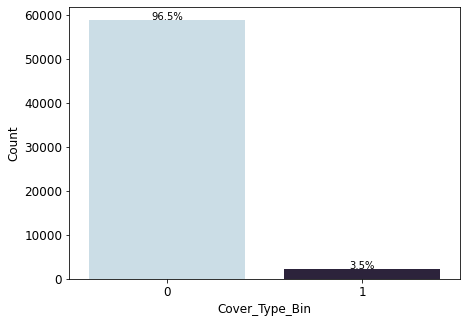

In [19]:
plt.figure(figsize=(7,5))
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x='Cover_Type_Bin', data=data_train, palette="ch:s=.25,rot=-.25")
plt.xticks(size=12)
plt.xlabel('Cover_Type_Bin', size=12)
plt.yticks(size=12)
plt.ylabel('Count', size=12)
percentage= b
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()


## Count plot for Multiclass distribution 

We can see that there are significantly more observations for classes 1 and 2 in this scenario, than for the other ones. 

In [20]:
a = (data_train['Cover_Type_Multi'].value_counts()/sum(data_train['Cover_Type_Multi'].value_counts()))*100
a = a.sort_index().to_list()
a




[36.38822410910402,
 48.66734419565289,
 6.232173884535947,
 0.4835589941972921,
 1.626069566927843,
 3.0570763531455922,
 3.5455528964364156]

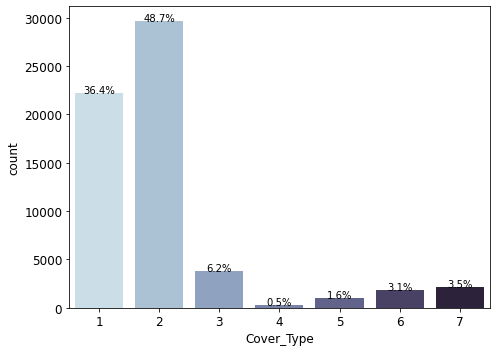

In [21]:
plt.figure(figsize=(7,5))
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x='Cover_Type_Multi', data=data_train, palette='ch:s=.25,rot=-.25')
plt.xticks(size=12)
plt.xlabel('Cover_Type', size=12)
plt.yticks(size=12)
plt.ylabel('count', size=12)
percentage = a
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()


## Variable correlation inspection

We now inspect the relationship between our target variable and other variables, in order to determine the ones that have a bigger impact. 

<AxesSubplot:>

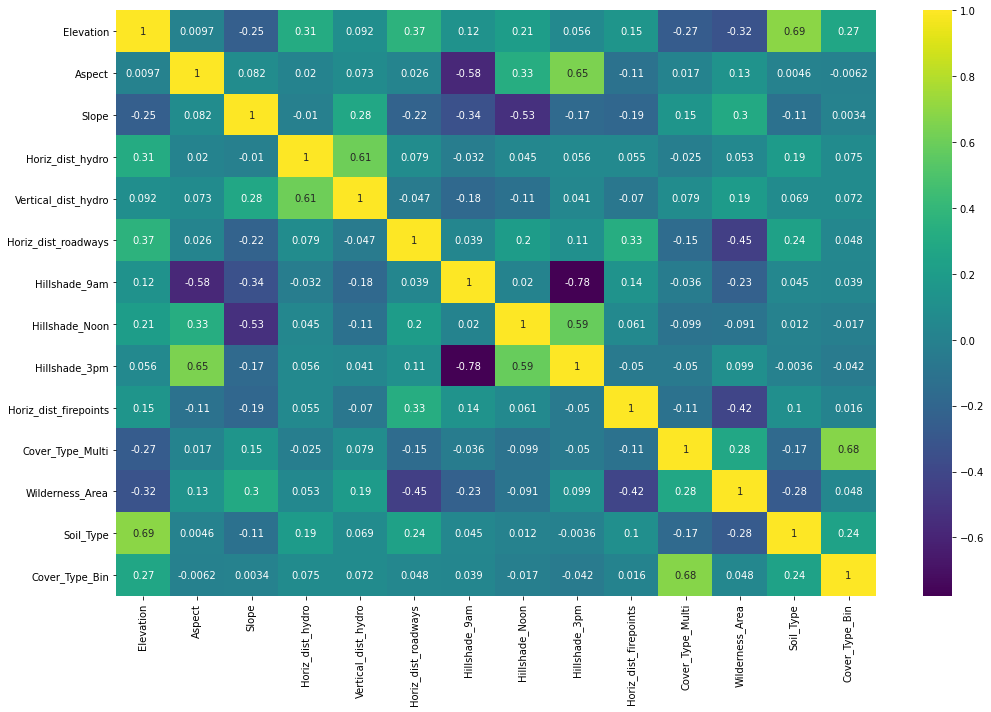

In [22]:
plt.figure(figsize=(15,10))
sns.heatmap(data= data_train.corr(), annot=True, cmap='viridis')

From the heatmap we can see the most correlated features with `Cover_Type_Bin` and `Cover_Type_Multi` and then we can explore these ones with the aim to obtain a better model. In the Binary case we can see that the most correlated features are, `Elevation` and `Soil_Type`. And in the Multi class case, we can see that `Slope`,`Elevation`,`Horiz_dist_roadways`, `Wilderness_Area` and `Soil_Type` are the variables that show more correlation. We will also explore this relations with violin plots for the non categorical variables. 

## Plots Cover Type vs. Features

In both cases we can see that `Elevation` has a sepparate distribution for both classes (binary case), and for most classes (multi-class case), and hence we can consider it an important attribute. 

## Binary Case

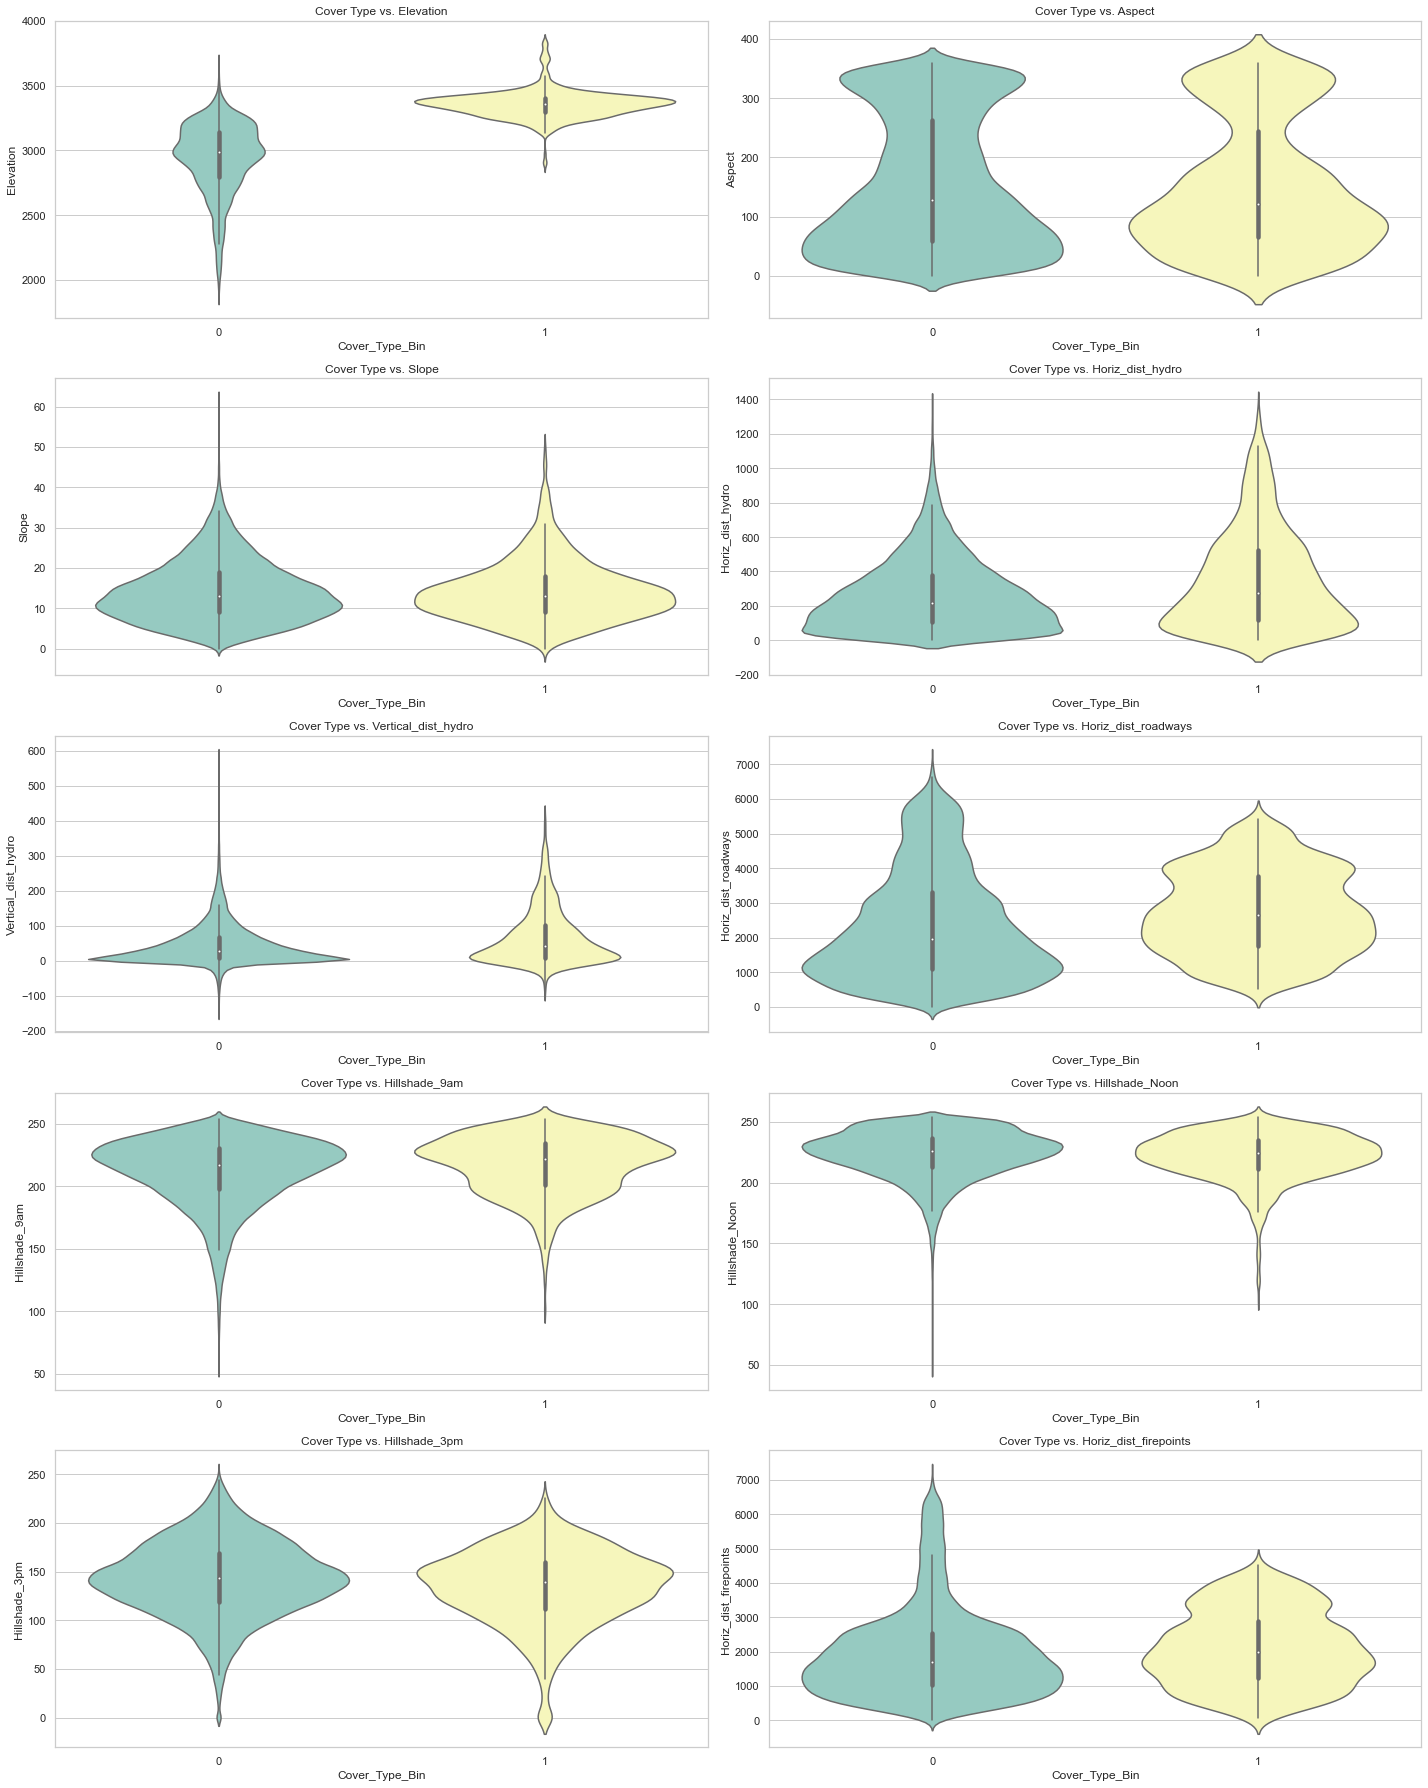

In [23]:
sns.set_theme(style="whitegrid")

# Iterate over variables in a list and create scatterplots for numerical variables and violinplots for categorical 
plt.figure(figsize=(20,25))
for i, var in enumerate(['Elevation','Aspect', 'Slope', 'Horiz_dist_hydro', 'Vertical_dist_hydro', 'Horiz_dist_roadways', 
                         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints']):
    plt.subplot(5, 2, i+1)
    sns.violinplot(x = "Cover_Type_Bin", y = var,data = data_train, palette='Set3')
    plt.title("Cover Type vs." +  " " + var)
    
plt.tight_layout()

## Multi-Class case

`Aspect` contains a normal distribution for a couple of classes. `Hillshade_3pm`we can see that is somewhat normal. 

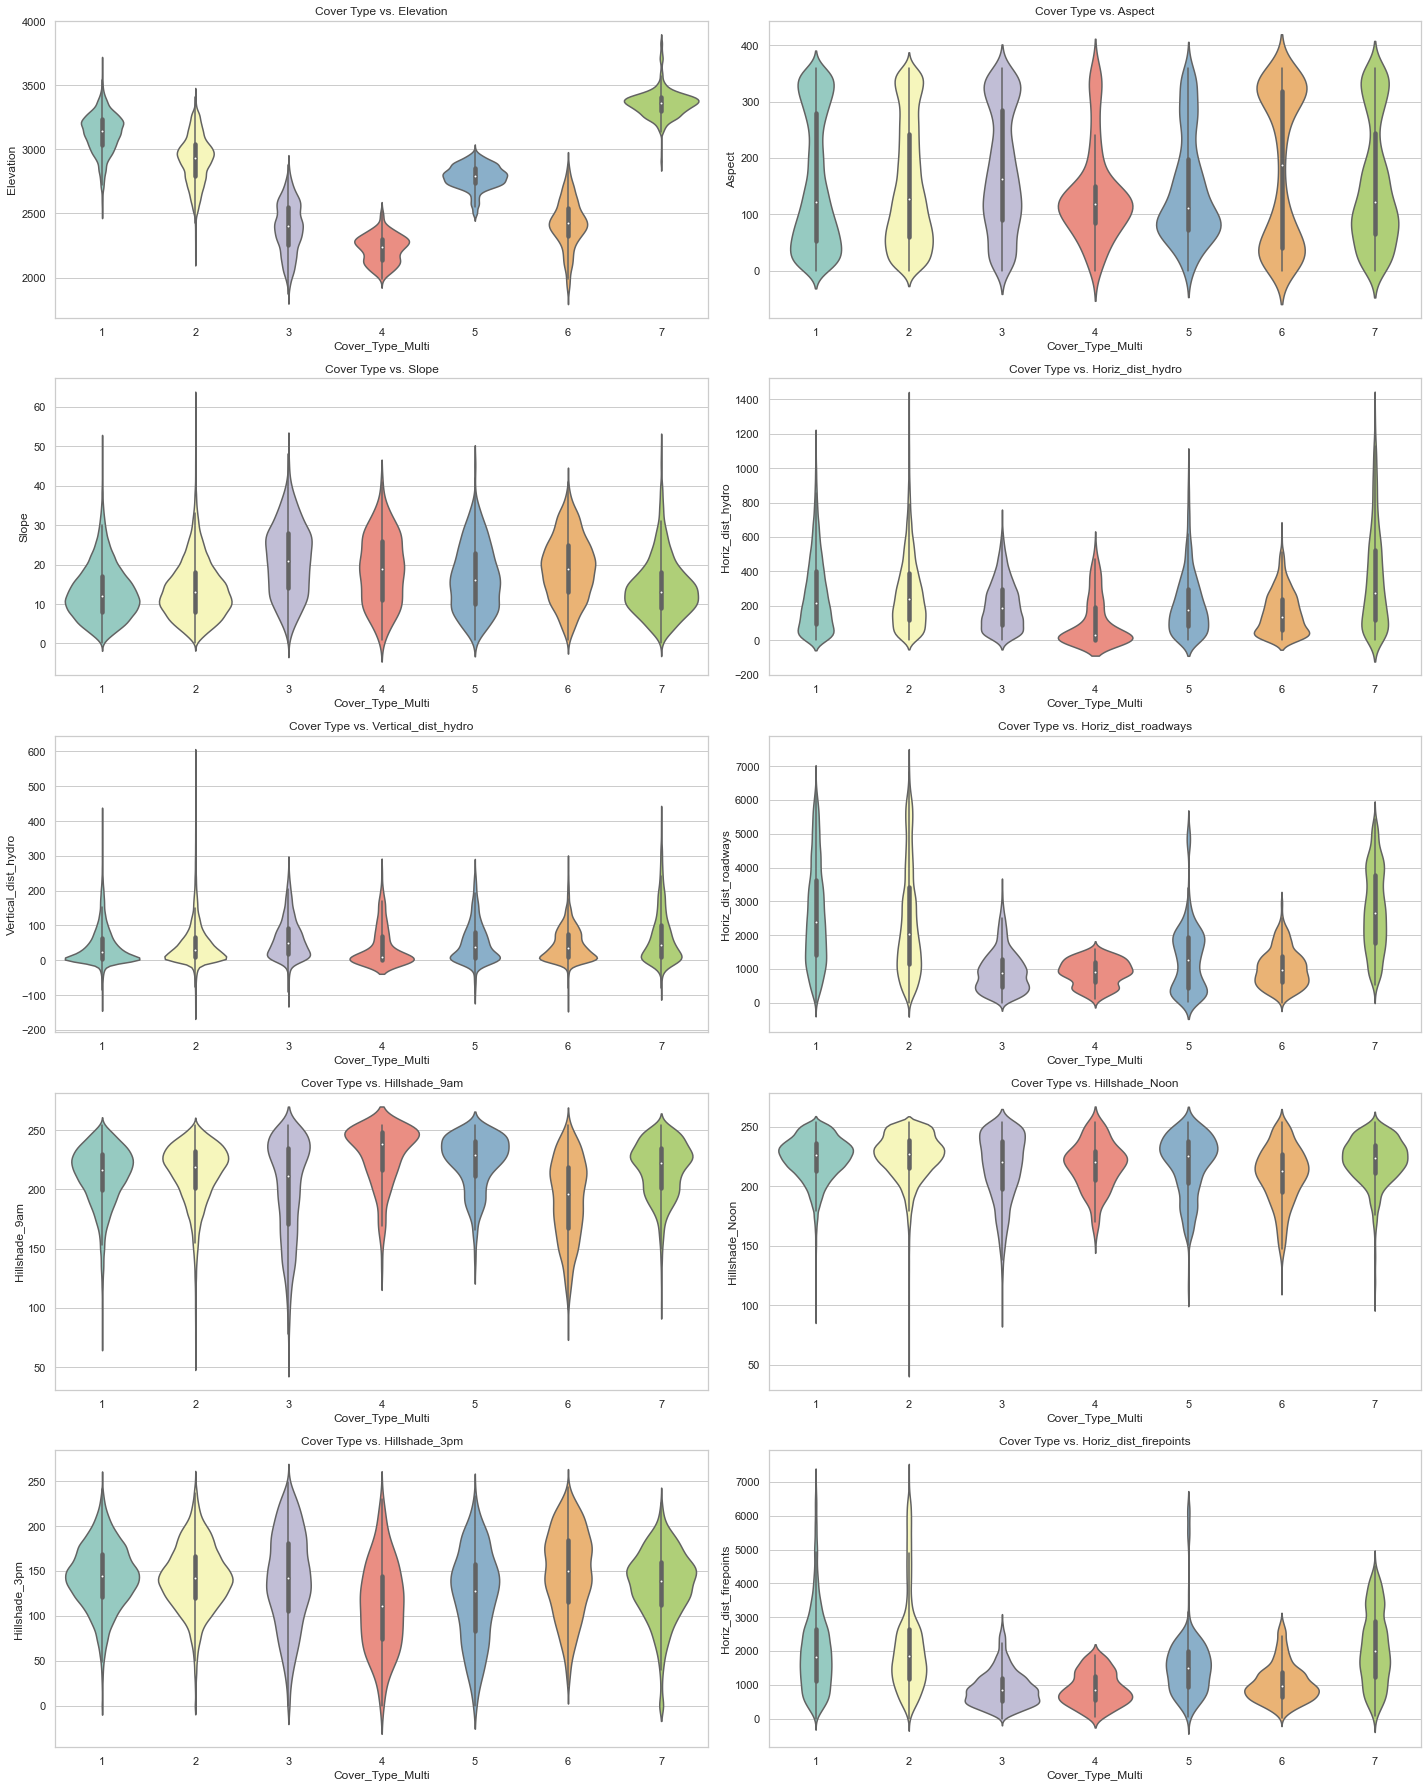

In [24]:
sns.set_theme(style="whitegrid")

# Iterate over variables in a list and create scatterplots for numerical variables and violinplots for categorical 
plt.figure(figsize=(20,25))
for i, var in enumerate(['Elevation','Aspect', 'Slope', 'Horiz_dist_hydro', 'Vertical_dist_hydro', 'Horiz_dist_roadways', 
                         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints']):
    plt.subplot(5, 2, i+1)
    sns.violinplot(x = "Cover_Type_Multi", y = var,data = data_train, palette='Set3')
    plt.title("Cover Type vs." +  " " + var)
    
plt.tight_layout()

# TRAIN DATA

## Preprocessing

In [25]:
data_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Cover_Type_Multi', 'Wilderness_Area', 'Soil_Type', 'Cover_Type_Bin'],
      dtype='object')

In [26]:
X_nc = data_train.drop(['Cover_Type_Bin', 'Cover_Type_Multi', 'Wilderness_Area', 'Soil_Type'], axis=1)
X_c=data_train[['Wilderness_Area', 'Soil_Type']]
X_c = pd.get_dummies(X_c, columns = ['Wilderness_Area', 'Soil_Type'])
y = data_train.Cover_Type_Bin
X_c# dummies for categorical data without standarizing 
X_nc


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints
0,3202,34,10,0,0,2760,219,218,134,1734
1,3113,251,13,192,40,5600,191,249,195,2555
2,2801,77,9,510,17,1728,232,223,122,1087
3,3165,82,9,319,56,4890,233,225,124,1452
4,3048,333,11,124,31,2823,196,226,170,666
...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713
61002,3170,170,25,417,61,2605,229,241,128,3350
61003,2994,170,13,134,18,1610,229,245,146,2394
61004,2543,135,4,124,17,524,227,238,145,1106


In [27]:
X_data = np.concatenate((X_nc,X_c),axis=1)
X_data

array([[3202,   34,   10, ...,    1,    0,    0],
       [3113,  251,   13, ...,    0,    0,    0],
       [2801,   77,    9, ...,    0,    0,    0],
       ...,
       [2994,  170,   13, ...,    0,    0,    0],
       [2543,  135,    4, ...,    0,    0,    0],
       [2661,  213,   19, ...,    0,    0,    0]])

In [28]:
X_data=pd.DataFrame(X_data)
X_data

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,3202,34,10,0,0,2760,219,218,134,1734,...,0,0,0,0,0,0,0,1,0,0
1,3113,251,13,192,40,5600,191,249,195,2555,...,0,0,0,0,0,0,0,0,0,0
2,2801,77,9,510,17,1728,232,223,122,1087,...,0,0,0,0,0,0,0,0,0,0
3,3165,82,9,319,56,4890,233,225,124,1452,...,0,0,0,0,0,0,0,0,0,0
4,3048,333,11,124,31,2823,196,226,170,666,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,...,0,0,0,0,0,0,0,1,0,0
61002,3170,170,25,417,61,2605,229,241,128,3350,...,0,0,1,0,0,0,0,0,0,0
61003,2994,170,13,134,18,1610,229,245,146,2394,...,0,0,1,0,0,0,0,0,0,0
61004,2543,135,4,124,17,524,227,238,145,1106,...,0,0,0,0,0,0,0,0,0,0


## Polynomial features with interactions = true

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials = pd.DataFrame(poly\
                           .fit_transform(X_nc))
polynomials

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,1.0,3202.0,34.0,10.0,0.0,0.0,2760.0,219.0,218.0,134.0,...,131767920.0,80994960.0,1.048099e+09,80625120.0,1.043313e+09,6.413026e+08,6397428.0,82784628.0,50885964.0,50653608.0
1,1.0,3113.0,251.0,13.0,192.0,40.0,5600.0,191.0,249.0,195.0,...,266330400.0,208572000.0,2.732828e+09,271908000.0,3.562692e+09,2.790060e+09,9274005.0,121513245.0,95160975.0,124058025.0
2,1.0,2801.0,77.0,9.0,510.0,17.0,1728.0,232.0,223.0,122.0,...,89399808.0,48909312.0,4.357740e+08,47011968.0,4.188689e+08,2.291570e+08,6311792.0,56237032.0,30766448.0,29572922.0
3,1.0,3165.0,82.0,9.0,319.0,56.0,4890.0,233.0,225.0,124.0,...,256358250.0,141281880.0,1.654365e+09,136431000.0,1.597563e+09,8.804347e+08,6500700.0,76121100.0,41951184.0,40510800.0
4,1.0,3048.0,333.0,11.0,124.0,31.0,2823.0,196.0,226.0,170.0,...,125047608.0,94062360.0,3.685031e+08,108459660.0,4.249067e+08,3.196201e+08,7530320.0,29501136.0,22191120.0,25587720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,1.0,3255.0,1.0,13.0,0.0,0.0,1552.0,201.0,215.0,151.0,...,67069680.0,47104752.0,2.224218e+08,50385680.0,2.379138e+08,1.670930e+08,6525465.0,30812295.0,21640263.0,23147545.0
61002,1.0,3170.0,170.0,25.0,417.0,61.0,2605.0,229.0,241.0,128.0,...,143767345.0,76357760.0,1.998426e+09,80359040.0,2.103147e+09,1.117024e+09,7064192.0,184883150.0,98195200.0,103340800.0
61003,1.0,2994.0,170.0,13.0,134.0,18.0,1610.0,229.0,245.0,146.0,...,90329050.0,53828740.0,8.826439e+08,57589700.0,9.443133e+08,5.627336e+08,8191330.0,134315370.0,80040996.0,85633380.0
61004,1.0,2543.0,135.0,4.0,124.0,17.0,524.0,227.0,238.0,145.0,...,28309624.0,17247460.0,1.315565e+08,18083240.0,1.379315e+08,8.403388e+07,7833770.0,59752756.0,36403990.0,38168060.0


## Polynomial features with interactions = False

In [30]:
polym = PolynomialFeatures(3)
X=polym.fit_transform(X_nc)
X=pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,1.0,3202.0,34.0,10.0,0.0,0.0,2760.0,219.0,218.0,134.0,...,10360232.0,6368216.0,82406616.0,3914408.0,50653608.0,6.554728e+08,2406104.0,31135704.0,4.029053e+08,5.213715e+09
1,1.0,3113.0,251.0,13.0,192.0,40.0,5600.0,191.0,249.0,195.0,...,15438249.0,12090195.0,158412555.0,9468225.0,124058025.0,1.625478e+09,7414875.0,97153875.0,1.272965e+09,1.667910e+10
2,1.0,2801.0,77.0,9.0,510.0,17.0,1728.0,232.0,223.0,122.0,...,11089567.0,6066938.0,54055423.0,3319132.0,29572922.0,2.634899e+08,1815848.0,16178908.0,1.441514e+08,1.284366e+09
3,1.0,3165.0,82.0,9.0,319.0,56.0,4890.0,233.0,225.0,124.0,...,11390625.0,6277500.0,73507500.0,3459600.0,40510800.0,4.743684e+08,1906624.0,22325952.0,2.614297e+08,3.061257e+09
4,1.0,3048.0,333.0,11.0,124.0,31.0,2823.0,196.0,226.0,170.0,...,11543176.0,8682920.0,34016616.0,6531400.0,25587720.0,1.002437e+08,4913000.0,19247400.0,7.540452e+07,2.954083e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,1.0,3255.0,1.0,13.0,0.0,0.0,1552.0,201.0,215.0,151.0,...,9938375.0,6979975.0,32958425.0,4902215.0,23147545.0,1.092993e+08,3442951.0,16257113.0,7.676372e+07,3.624671e+08
61002,1.0,3170.0,170.0,25.0,417.0,61.0,2605.0,229.0,241.0,128.0,...,13997521.0,7434368.0,194571350.0,3948544.0,103340800.0,2.704622e+09,2097152.0,54886400.0,1.436480e+09,3.759538e+10
61003,1.0,2994.0,170.0,13.0,134.0,18.0,1610.0,229.0,245.0,146.0,...,14706125.0,8763650.0,143699850.0,5222420.0,85633380.0,1.404153e+09,3112136.0,51030504.0,8.367605e+08,1.372058e+10
61004,1.0,2543.0,135.0,4.0,124.0,17.0,524.0,227.0,238.0,145.0,...,13481272.0,8213380.0,62648264.0,5003950.0,38168060.0,2.911302e+08,3048625.0,23253650.0,1.773692e+08,1.352899e+09


## Standarazing the data

In [31]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_s = polynomials.copy()
X_s = scaler.fit_transform(X_s) #non categorical vars standarized
X_s.shape

(61006, 176)

In [32]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_ss = X.copy()
X_ss = scaler.fit_transform(X_ss) #non categorical vars standarized
X_ss.shape

(61006, 286)

In [33]:
X_c = np.array(X_c) # array for dummy variables
X_c.shape

(61006, 43)

In [34]:
X_bin_true = np.concatenate((X_s,X_c),axis=1) # joining the standarized variables with the categorical dummies 
X_bin_true.shape

(61006, 219)

In [35]:
X_bin_false = np.concatenate((X_ss,X_c),axis=1) # joining the standarized variables with the categorical dummies 
X_bin_false.shape

(61006, 329)

# TEST DATA 

## Preprocessing

In [36]:
data_test.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area', 'Soil_Type'],
      dtype='object')

In [37]:
Xtest_nc = data_test.drop(['Wilderness_Area', 'Soil_Type'], axis=1)
Xtest_c=data_test[['Wilderness_Area', 'Soil_Type']]
Xtest_c = pd.get_dummies(Xtest_c, columns = ['Wilderness_Area', 'Soil_Type'])
Xtest_c # dummies for categorical data without standarizing 

,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13069,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13070,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13071,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Polynomial features with interactions = true


In [38]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials_test = pd.DataFrame(poly\
                           .fit_transform(Xtest_nc))
polynomials_test

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,1.0,3111.0,72.0,13.0,283.0,76.0,630.0,235.0,214.0,109.0,...,31682700.0,16137450.0,7.387695e+07,14695380.0,6.727518e+07,3.426633e+07,5481610.0,25094710.0,12781885.0,11639674.0
1,1.0,2768.0,0.0,20.0,134.0,26.0,912.0,186.0,198.0,146.0,...,33587136.0,24766272.0,3.348536e+08,26364096.0,3.564570e+08,2.628420e+08,5376888.0,72698472.0,53605944.0,57064392.0
2,1.0,3360.0,272.0,13.0,685.0,178.0,4502.0,185.0,244.0,198.0,...,203220280.0,164908260.0,2.200443e+09,217500624.0,2.902205e+09,2.355068e+09,8937720.0,119259880.0,96776460.0,127640304.0
3,1.0,2413.0,0.0,3.0,201.0,18.0,560.0,215.0,233.0,156.0,...,28053200.0,18782400.0,1.042664e+08,20354880.0,1.129957e+08,7.565376e+07,7814820.0,43382270.0,29045640.0,31477368.0
4,1.0,2815.0,54.0,11.0,42.0,9.0,2313.0,226.0,217.0,123.0,...,113434146.0,64296774.0,1.498167e+09,61736283.0,1.438506e+09,8.153741e+08,6032166.0,140554372.0,79669068.0,76496406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,1.0,3053.0,181.0,12.0,150.0,-13.0,2162.0,224.0,248.0,155.0,...,120103424.0,75064640.0,1.853370e+09,83107280.0,2.051946e+09,1.282466e+09,8610560.0,212597504.0,132873440.0,147109880.0
13069,1.0,2940.0,218.0,27.0,30.0,4.0,1433.0,179.0,253.0,197.0,...,64896271.0,50531879.0,6.710223e+08,71422153.0,9.484282e+08,7.384994e+08,8921539.0,118470792.0,92248008.0,130384056.0
13070,1.0,3014.0,208.0,4.0,283.0,37.0,4716.0,217.0,243.0,162.0,...,248679396.0,165786264.0,1.105242e+08,185650056.0,1.237667e+08,8.251114e+07,8542422.0,5694948.0,3796632.0,4251528.0
13071,1.0,2836.0,11.0,14.0,258.0,41.0,3342.0,204.0,210.0,141.0,...,143171280.0,96129288.0,7.492630e+08,98956620.0,7.713002e+08,5.178730e+08,6040440.0,47081160.0,31611636.0,32541390.0


## Polynomial features with interactions = False

In [39]:
polym_test = PolynomialFeatures(3)
X_test=polym_test.fit_transform(Xtest_nc)
X_test=pd.DataFrame(X_test)
X_test

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,1.0,3111.0,72.0,13.0,283.0,76.0,630.0,235.0,214.0,109.0,...,9800344.0,4991764.0,22852204.0,2542534.0,11639674.0,5.328621e+07,1295029.0,5928619.0,2.714111e+07,1.242515e+08
1,1.0,2768.0,0.0,20.0,134.0,26.0,912.0,186.0,198.0,146.0,...,7762392.0,5723784.0,77388696.0,4220568.0,57064392.0,7.715418e+08,3112136.0,42077784.0,5.689147e+08,7.692038e+09
2,1.0,3360.0,272.0,13.0,685.0,178.0,4502.0,185.0,244.0,198.0,...,14526784.0,11788128.0,157294112.0,9565776.0,127640304.0,1.703160e+09,7762392.0,103576968.0,1.382072e+09,1.844159e+10
3,1.0,2413.0,0.0,3.0,201.0,18.0,560.0,215.0,233.0,156.0,...,12649337.0,8469084.0,47014274.0,5670288.0,31477368.0,1.747397e+08,3796416.0,21074976.0,1.169931e+08,6.494619e+08
4,1.0,2815.0,54.0,11.0,42.0,9.0,2313.0,226.0,217.0,123.0,...,10218313.0,5791947.0,134957074.0,3282993.0,76496406.0,1.782428e+09,1860867.0,43359714.0,1.010317e+09,2.354120e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,1.0,3053.0,181.0,12.0,150.0,-13.0,2162.0,224.0,248.0,155.0,...,15252992.0,9533120.0,235375808.0,5958200.0,147109880.0,3.632190e+09,3723875.0,91943675.0,2.270119e+09,5.604997e+10
13069,1.0,2940.0,218.0,27.0,30.0,4.0,1433.0,179.0,253.0,197.0,...,16194277.0,12609773.0,167447544.0,9818677.0,130384056.0,1.731394e+09,7645373.0,101524344.0,1.348161e+09,1.790248e+10
13070,1.0,3014.0,208.0,4.0,283.0,37.0,4716.0,217.0,243.0,162.0,...,14348907.0,9565938.0,6377292.0,6377292.0,4251528.0,2.834352e+06,4251528.0,2834352.0,1.889568e+06,1.259712e+06
13071,1.0,2836.0,11.0,14.0,258.0,41.0,3342.0,204.0,210.0,141.0,...,9261000.0,6218100.0,48465900.0,4175010.0,32541390.0,2.536382e+08,2803221.0,21849219.0,1.702999e+08,1.327373e+09


## Standarazing the data 

In [40]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Xtest_s = polynomials_test.copy()
Xtest_s = scaler.fit_transform(Xtest_s) #non categorical vars standarized
Xtest_s.shape

(13073, 176)

In [41]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Xtest_ss = X_test.copy()
Xtest_ss = scaler.fit_transform(Xtest_ss) #non categorical vars standarized
Xtest_ss.shape

(13073, 286)

In [42]:
Xtest_c = np.array(Xtest_c) # array for dummy variables
Xtest_c.shape

(13073, 43)

In [43]:
Xtest_bin_true = np.concatenate((Xtest_s,Xtest_c),axis=1) # joining the standarized variables with the categorical dummies 
Xtest_bin_true.shape

(13073, 219)

In [44]:
Xtest_bin_false = np.concatenate((Xtest_ss,Xtest_c),axis=1) # joining the standarized variables with the categorical dummies 
Xtest_bin_false.shape

(13073, 329)

First, we have separated the data with the relevanyt variables, and removed `Cover_Type` which is the target variable in the regression. And for the correct standarization we have separated the set data set in two, the categorical and non categorical variables.

It is impotrtant to only standarize the continous variables and create the dummies for the categorical features separately in order to not standarize them. Also, it is important to create feature interactions before standarization of the data. For this purpose, we apply polynomial features to the non categorical features and try with using interaction_only=True, and False and find out that is better to leave it like the default value which is false and has not only the interactions. 

Following this we have standarized the data with the polynomial features and then we have added teh dummies we created beforehand in order to have the full dataframe and have a more accurate model. 


# Binary Logistic Regression without balancing 

For the binary logistic regression and the multi class we have performed a grid search in order to have a sense of the best paramters for the model. Despite the paramaters shown in the grid search, we have found that the best C for this model is of 1.0, gives the most efficient and accurate performancd for the model in every case. The solver, stays liblinear, and the penalty is l2. We also, have found as mentioned previously that the best polynomial fit is the one with interaction_only = False. 

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
Xbin_tune=X_bin_true.copy()
y_tune=y.copy()
Xbin_tune, y_tune = make_blobs(n_samples=1000, centers=2, cluster_std=20)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
penalty = ['l1', 'l2'] 
C = [0.001,0.01, 0.1, 1, 10, 100, 1000]  
solver = ['liblinear', 'saga'] 
param_grid = dict(penalty=penalty, 
C=C, 
solver=solver) 
logistic = LogisticRegression() 
grid = GridSearchCV(estimator=logistic, 
param_grid=param_grid, 
scoring='roc_auc', 
verbose=0, 
n_jobs=-1, cv = cv) 
grid_result = grid.fit(Xbin_tune, y_tune) 
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 


Best Score:  0.6181999999999999
Best Params:  {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


In [47]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
Xbin_tunne=X_bin_false.copy()
y_tunne=y.copy()
Xbin_tunne, y_tunne = make_blobs(n_samples=1000, centers=2, cluster_std=20)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
penalty = ['l1', 'l2'] 
C = [0.001,0.01, 0.1, 1, 10, 100, 1000]  
solver = ['liblinear', 'saga'] 
param_grid = dict(penalty=penalty, 
C=C, 
solver=solver) 
logistic = LogisticRegression() 
grid = GridSearchCV(estimator=logistic, 
param_grid=param_grid, 
scoring='roc_auc', 
verbose=0, 
n_jobs=-1, cv = cv) 
grid_result = grid.fit(Xbin_tunne, y_tunne) 
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Best Score:  0.6731066666666666
Best Params:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [48]:
lregr = LogisticRegression(penalty='l2', C=1.0,
                           dual=False, tol=0.0001,
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=1000, verbose=0, warm_start=False)

In [49]:
model_false = lregr.fit(X_bin_false, y)
y_prob_imb_bin_false = lregr.predict_proba(X_bin_false)
y_prob_imb_bin_false

array([[4.92053982e-01, 5.07946018e-01],
       [9.99925083e-01, 7.49166173e-05],
       [9.99990049e-01, 9.95124402e-06],
       ...,
       [9.99876147e-01, 1.23852803e-04],
       [9.99998945e-01, 1.05485611e-06],
       [9.99998140e-01, 1.85986992e-06]])

In [50]:
y_pred_bin_false = lregr.predict(X_bin_false)

In [51]:
model_true = lregr.fit(X_bin_true, y)
y_prob_imb_bin = model_true.predict_proba(X_bin_true)
y_prob_imb_bin

array([[6.33067464e-01, 3.66932536e-01],
       [9.99753606e-01, 2.46394346e-04],
       [9.99993323e-01, 6.67700681e-06],
       ...,
       [9.99850998e-01, 1.49002111e-04],
       [9.99998694e-01, 1.30580261e-06],
       [9.99999142e-01, 8.57519526e-07]])

In [52]:
y_pred_bin_true = lregr.predict(X_bin_true)

AUC:  0.985193853215538


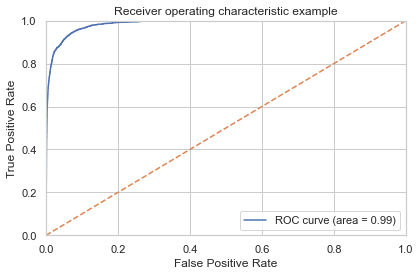

In [53]:
# Step 5: Assess expected accuracy: AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
class_labels = [0,1]
roc_auc_score(y, y_prob_imb_bin[:, 1])
get_auc(y, y_prob_imb_bin, class_labels, column=1, plot=True)

In [54]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y, y_pred_bin_true )))

Model accuracy score: 0.9832


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred_bin_true ))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     58843
           1       0.83      0.66      0.74      2163

    accuracy                           0.98     61006
   macro avg       0.91      0.83      0.86     61006
weighted avg       0.98      0.98      0.98     61006



AUC:  0.9881670752741359


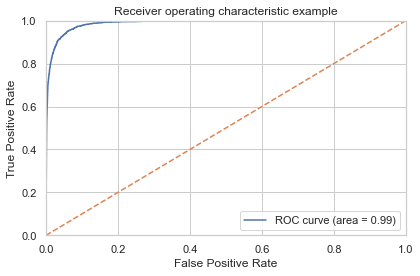

In [56]:
class_labels = [0,1]
roc_auc_score(y, y_prob_imb_bin_false[:, 1])
get_auc(y, y_prob_imb_bin_false, class_labels, column=1, plot=True)

In [57]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y, y_pred_bin_false )))

Model accuracy score: 0.9844


In [58]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred_bin_false ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     58843
           1       0.84      0.69      0.76      2163

    accuracy                           0.98     61006
   macro avg       0.91      0.84      0.87     61006
weighted avg       0.98      0.98      0.98     61006



In [59]:
from sklearn.metrics import confusion_matrix

[[58560   283]
 [  670  1493]]


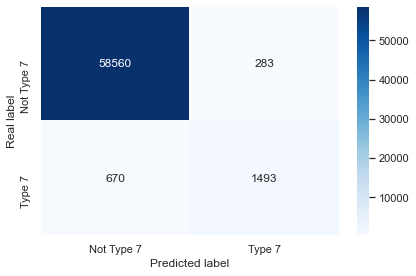

In [60]:
#confusion matrix (original by default cut-off 0.5)
feature_names = data_train.columns
cm1=confusion_matrix(y_pred=y_pred_bin_false , y_true=y, labels=[0,1])
print(cm1)
class_labels = ["Not Type 7","Type 7"] 
plot_confusion_matrix(cm1, class_labels) # Plotting confusion matrix

[[58544   299]
 [  725  1438]]


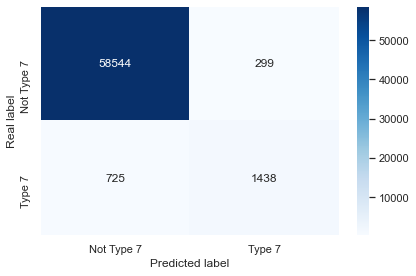

In [61]:
#confusion matrix (original by default cut-off 0.5)
feature_names = data_train.columns
cm1=confusion_matrix(y_pred=y_pred_bin_true , y_true=y, labels=[0,1])
print(cm1)
class_labels = ["Not Type 7","Type 7"] 
plot_confusion_matrix(cm1, class_labels) # Plotting confusion matrix

# Tackle Class Imbalance for the Binary Case

In [62]:
lr = LogisticRegression(penalty='l2', C=1.0,
                           dual=False, tol=0.0001,
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=1000, verbose=0, warm_start=False, class_weight='balanced')
lr.fit(X_bin_false,y)



LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [63]:
y_imb_bin = lr.predict_proba(X_bin_false)
data_train["prob_imb_binary"] = y_imb_bin[:,1]

In [64]:
q1 = y.sum()/len(y)
r1 = 0.5

def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

data_train["prob_imb_new"] = data_train["prob_imb_binary"].apply(reweight,args=(q1,r1))

In [65]:
prob_test = lr.predict_proba(Xtest_bin_false)

In [66]:
predictions = pd.DataFrame({"Index": data_test.index, "Cover_Type": prob_test[:,1]})

In [67]:
test_predictions_submit =  pd.DataFrame({"Index": Index, "Cover_Type": prob_test[:,1]})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_2.csv", index = False)

# Multi-Class Logistic Regression 

Running the logistic regression, con ya balanced y aplicando el reweight para que las predicciones no esten mal. Usamos la de antes y ahora definimos la función de reweight. 

In [68]:
X_multi=X_bin_false.copy()
y_multi = data_train.Cover_Type_Multi

In [69]:
from sklearn.linear_model import LogisticRegression
lr_m = LogisticRegression(penalty='l2', C=1.0,
                           dual=False, tol=0.0001,
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='newton-cg', max_iter=1000, verbose=0, warm_start=False, class_weight='balanced', multi_class='multinomial')
lr_m.fit(X_multi,y_multi)



LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', solver='newton-cg')

In [70]:
#from sklearn.model_selection import cross_val_predict
#y_probabilities = cross_val_predict(lr_m, X_multi, y_multi, method='predict_proba', cv = 5)

In [71]:
#y_probabilities.shape

In [72]:
y_imb_multi = lr_m.predict_proba(X_multi)
y_imb_multi.shape

(61006, 7)

In [73]:
ytest_imb_multi = lr_m.predict_proba(Xtest_bin_false)
ytest_imb_multi.shape

(13073, 7)

In [74]:
multi=(data_train['Cover_Type_Multi'].value_counts()/sum(data_train['Cover_Type_Multi'].value_counts()))
multi[1]


0.3638822410910402

## Reweight function for correction of the biased sample

In [75]:
def reweight_multi(classes, probs, rj):
    q = (classes.value_counts()/classes.value_counts().sum()).sort_index()
    q.index = range(1, len(q)+1)
    reweighted_probs = []
    for pi in probs:
        tot = 0
        for j in range(1,len(q)+1):
            tot = tot + pi[j-1]*(q[j]/rj)
        probs_rew_row = []
        for i in range(1,len(q)+1):
            w = (pi[i-1]*(q[i]/rj))/tot
            probs_rew_row.append(w)
        reweighted_probs.append(probs_rew_row)
    return np.array(reweighted_probs)


In [76]:
#reweight_cv = reweight_multi(data_train['Cover_Type_Multi'], y_probabilities, 1/7)
#reweight_cv

In [77]:
#y_pred = cross_val_predict(lr_m, X_multi, y_multi, cv = 5)

In [78]:
#y_pred.shape

In [79]:
#from sklearn.metrics import accuracy_score


#print ("Accuracy (cross-validated): ", accuracy_score(y_multi, y_pred))

####  Classification report
#from sklearn.metrics import classification_report

#print (classification_report(y_multi, y_pred))

In [80]:
reweight = reweight_multi(data_train['Cover_Type_Multi'], y_imb_multi, 1/7)
reweight

array([[5.52441934e-01, 3.51720081e-02, 4.41072573e-08, ...,
        8.60601587e-06, 1.42825707e-08, 4.12377393e-01],
       [5.94803058e-01, 4.05154837e-01, 2.44962121e-12, ...,
        3.47252749e-08, 1.44608546e-15, 4.20696146e-05],
       [3.63780074e-02, 9.63519629e-01, 8.13721136e-06, ...,
        9.41700564e-05, 4.50380510e-08, 1.15045933e-08],
       ...,
       [3.25632424e-01, 6.71619248e-01, 8.24437288e-06, ...,
        2.71489116e-03, 5.05369067e-06, 2.01389038e-05],
       [4.65913422e-03, 2.32297285e-01, 6.77220584e-01, ...,
        3.51224003e-04, 7.99403808e-02, 3.93327821e-11],
       [2.21522441e-02, 8.57185401e-01, 6.98771198e-02, ...,
        4.30288952e-02, 7.75633253e-03, 6.89784754e-09]])

In [81]:
reweight_test= reweight_multi(data_train['Cover_Type_Multi'], ytest_imb_multi, 1/7)
reweight_test

array([[4.77168873e-01, 5.17502289e-01, 1.27884660e-06, ...,
        8.84209094e-04, 1.87658073e-06, 4.44147419e-03],
       [1.53056804e-01, 8.24683152e-01, 4.90106488e-03, ...,
        8.83649760e-03, 8.52206894e-03, 4.12693212e-07],
       [2.93482828e-01, 1.25886462e-02, 2.18442804e-09, ...,
        5.80120828e-15, 9.28059450e-18, 6.93928524e-01],
       ...,
       [1.87025600e-01, 8.12725494e-01, 3.58874935e-08, ...,
        2.48775290e-04, 9.14329487e-14, 9.46644063e-08],
       [1.05280937e-01, 8.46256549e-01, 9.03744089e-04, ...,
        4.54263918e-02, 2.13185652e-03, 5.21836706e-07],
       [1.90355214e-01, 8.09619043e-01, 1.66642115e-18, ...,
        1.45398239e-20, 4.87467723e-31, 2.57436834e-05]])

In [82]:
pd.DataFrame(reweight)

,0,1,2,3,4,5,6
0,0.552442,0.035172,4.410726e-08,3.673513e-28,8.606016e-06,1.428257e-08,4.123774e-01
1,0.594803,0.405155,2.449621e-12,5.308297e-54,3.472527e-08,1.446085e-15,4.206961e-05
2,0.036378,0.963520,8.137211e-06,3.459380e-11,9.417006e-05,4.503805e-08,1.150459e-08
3,0.467500,0.532092,1.025134e-09,1.157859e-39,7.375883e-06,2.371136e-14,4.007327e-04
4,0.786872,0.212196,1.211510e-09,4.153568e-26,9.045005e-04,2.311439e-09,2.736402e-05
...,...,...,...,...,...,...,...
61001,0.874303,0.028152,7.615137e-13,6.120055e-25,1.894124e-07,2.173702e-13,9.754453e-02
61002,0.585054,0.412788,4.388138e-09,2.928720e-22,5.755489e-07,3.388889e-12,2.157319e-03
61003,0.325632,0.671619,8.244373e-06,2.519325e-17,2.714891e-03,5.053691e-06,2.013890e-05
61004,0.004659,0.232297,6.772206e-01,5.531391e-03,3.512240e-04,7.994038e-02,3.933278e-11


In [83]:
pd.DataFrame(reweight_test)

,0,1,2,3,4,5,6
0,0.477169,0.517502,1.278847e-06,2.491806e-17,8.842091e-04,1.876581e-06,4.441474e-03
1,0.153057,0.824683,4.901065e-03,1.928612e-11,8.836498e-03,8.522069e-03,4.126932e-07
2,0.293483,0.012589,2.184428e-09,3.274327e-39,5.801208e-15,9.280594e-18,6.939285e-01
3,0.000272,0.112473,4.167872e-01,3.749679e-07,4.833613e-03,4.656341e-01,2.905267e-13
4,0.194042,0.798803,2.129705e-06,2.763198e-15,7.141207e-03,6.443914e-06,4.823482e-06
...,...,...,...,...,...,...,...
13068,0.649545,0.350229,1.195517e-09,1.170472e-23,1.652533e-05,1.401049e-10,2.098411e-04
13069,0.324457,0.664005,5.844023e-06,5.324163e-17,1.152875e-02,2.394512e-06,7.479180e-07
13070,0.187026,0.812725,3.588749e-08,1.002478e-31,2.487753e-04,9.143295e-14,9.466441e-08
13071,0.105281,0.846257,9.037441e-04,4.588252e-20,4.542639e-02,2.131857e-03,5.218367e-07


In [84]:
predicted_classes = []
for row in reweight:
    prediction = row.argmax() + 1
    predicted_classes.append(prediction)
    
    
prediction_multi = np.array(predicted_classes)
prediction_multi

array([1, 1, 2, ..., 2, 3, 2])

In [85]:
predicted_test = []
for row in reweight_test:
    prediction_test = row.argmax() + 1
    predicted_test.append(prediction_test)
    
    
prediction_test = np.array(predicted_test)
prediction_test

array([2, 2, 7, ..., 2, 2, 2])

In [86]:
from sklearn.metrics import accuracy_score


print ("Accuracy (cross-validated): ", accuracy_score(y_multi, prediction_multi))

####  Classification report
from sklearn.metrics import classification_report

print (classification_report(y_multi, prediction_multi))

Accuracy (cross-validated):  0.748483755696161
              precision    recall  f1-score   support

           1       0.73      0.74      0.74     22199
           2       0.77      0.80      0.78     29690
           3       0.72      0.82      0.76      3802
           4       0.79      0.68      0.73       295
           5       0.55      0.14      0.22       992
           6       0.54      0.43      0.48      1865
           7       0.81      0.67      0.73      2163

    accuracy                           0.75     61006
   macro avg       0.70      0.61      0.64     61006
weighted avg       0.75      0.75      0.74     61006



In [87]:
cm_train =  confusion_matrix(y_pred=prediction_multi, y_true=y_multi, labels=[1,2,3,4,5,6,7])
cm_train

array([[16350,  5490,    11,     0,    10,    11,   327],
       [ 5206, 23620,   428,     1,    98,   314,    23],
       [    0,   321,  3099,    44,     4,   334,     0],
       [    0,     2,    71,   202,     0,    20,     0],
       [   24,   794,    26,     0,   140,     8,     0],
       [    0,   356,   694,     9,     3,   803,     0],
       [  695,    20,     0,     0,     0,     0,  1448]])

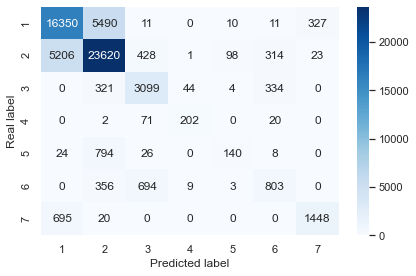

In [88]:
class_labels = ["1","2", "3", '4', '5', '6', '7'] 
plot_confusion_matrix(cm_train, class_labels)

In [89]:
#cm_m =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=[1,2,3,4,5,6,7])
#cm_m

In [90]:
#class_labels = ["1","2", "3", '4', '5', '6', '7'] 
#plot_confusion_matrix(cm_m, class_labels) # Plotting confusion matrix

In [92]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit_reweighted =  pd.DataFrame({"Index": Index, "Cover_Type": prediction_test})
test_predictions_submit_reweighted.to_csv("test_LogReg_predictions_submit_multi_bal2.csv", index = False)